# Esquema del modelo definitivo

## I. Librerias y funciones

In [1]:
#Librerias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import pickle


In [2]:
# Función para convertir los datos en secuencias de tiempo
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

## II. Procesado del DF

In [4]:
#Covid transofromar en niveles de restricciones
df = pd.read_csv(r'C:/Users/minip/OneDrive - Universidad de Málaga/Documentos/4Geek/Proyecto final/AMH-proyecto-final/data/DF_modelos/df_servicios_total.csv')
df

,Sector_Economic,consumo,año,fecha,findesemana,festivos,lectivos,COVID,pernoctaciones,tmed,prec,velmedia,poblacion,PIB,Empleo
0,Serveis,7338057,2019.0,2019-01-01,0,1,0,0,531000,8.590909,0.0,1.417647,5628011,42493,1926300
1,Serveis,10409953,2019.0,2019-01-02,0,0,0,0,531000,6.617391,0.3,2.152941,5628011,42493,1926300
2,Serveis,10625634,2019.0,2019-01-03,0,0,0,0,531000,5.604348,0.1,1.676471,5628011,42493,1926300
3,Serveis,10570866,2019.0,2019-01-04,0,0,0,0,531000,5.004348,0.0,1.335294,5628011,42493,1926300
4,Serveis,8572617,2019.0,2019-01-05,1,0,0,0,531000,6.173913,0.0,2.247059,5628011,42493,1926300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,Serveis,11199017,2024.0,2024-06-26,0,0,0,0,743000,22.623810,0.0,2.168750,5884873,54176,2197100
2004,Serveis,11032570,2024.0,2024-06-27,0,0,0,0,743000,23.776190,0.0,1.912500,5884873,54176,2197100
2005,Serveis,11226249,2024.0,2024-06-28,0,0,0,0,743000,24.452381,15.5,2.637500,5884873,54176,2197100
2006,Serveis,9529016,2024.0,2024-06-29,1,0,0,0,743000,20.942857,223.6,2.050000,5884873,54176,2197100


In [5]:
df = df.drop(columns=['Sector_Economic','año','velmedia','COVID','prec','Empleo','PIB','lectivos']) 

In [6]:
#Analizar los valores de df
df

,consumo,fecha,findesemana,festivos,pernoctaciones,tmed,poblacion
0,7338057,2019-01-01,0,1,531000,8.590909,5628011
1,10409953,2019-01-02,0,0,531000,6.617391,5628011
2,10625634,2019-01-03,0,0,531000,5.604348,5628011
3,10570866,2019-01-04,0,0,531000,5.004348,5628011
4,8572617,2019-01-05,1,0,531000,6.173913,5628011
...,...,...,...,...,...,...,...
2003,11199017,2024-06-26,0,0,743000,22.623810,5884873
2004,11032570,2024-06-27,0,0,743000,23.776190,5884873
2005,11226249,2024-06-28,0,0,743000,24.452381,5884873
2006,9529016,2024-06-29,1,0,743000,20.942857,5884873


In [7]:
#Eliminar consumos anomalos
index_primera_menor_1000 = df[df['consumo'] < 200000].index.min()

# Eliminar todas las filas desde ese índice en adelante
if index_primera_menor_1000 is not None:
    df = df.loc[:index_primera_menor_1000-1]

df

,consumo,fecha,findesemana,festivos,pernoctaciones,tmed,poblacion
0,7338057,2019-01-01,0,1,531000,8.590909,5628011
1,10409953,2019-01-02,0,0,531000,6.617391,5628011
2,10625634,2019-01-03,0,0,531000,5.604348,5628011
3,10570866,2019-01-04,0,0,531000,5.004348,5628011
4,8572617,2019-01-05,1,0,531000,6.173913,5628011
...,...,...,...,...,...,...,...
1943,7444394,2024-04-27,1,0,743000,14.108696,5884873
1944,6943975,2024-04-28,1,0,743000,12.460870,5884873
1945,9239400,2024-04-29,0,0,743000,11.617391,5884873
1946,9165075,2024-04-30,0,0,743000,13.543478,5884873


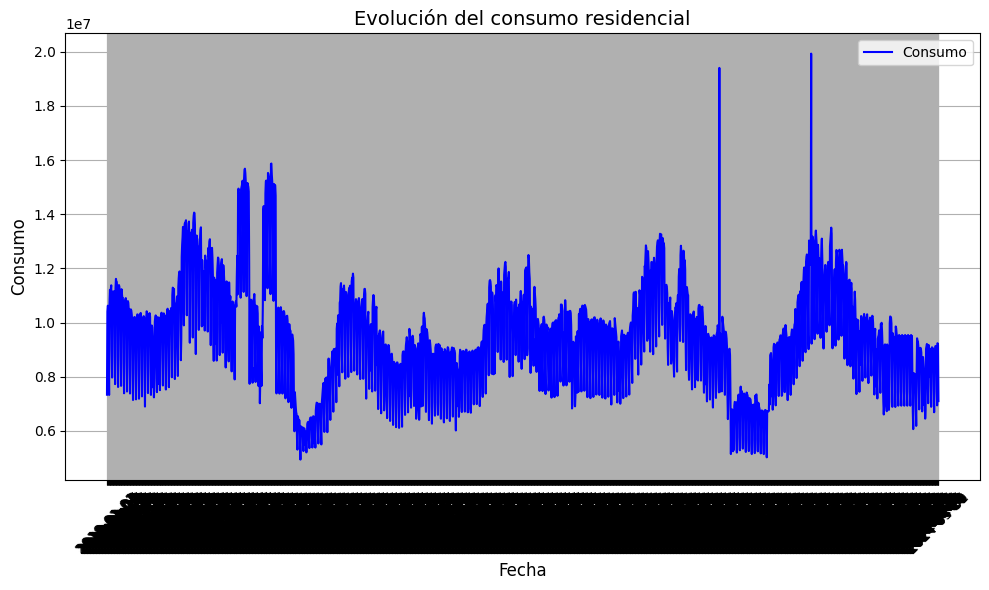

In [8]:
# Crear la gráfica temporal
plt.figure(figsize=(10,6))
plt.plot(df['fecha'], df['consumo'], label='Consumo', color='b')

# Personalizar el gráfico
plt.title('Evolución del consumo residencial', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Consumo', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)  # Rotar las etiquetas de fechas si son muchas
plt.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()

In [9]:
#Consumo previo 3 dias
df['t-1'] = df['consumo'].shift(1)
#df['t-2'] = df['consumo'].shift(2)
#df['t-3'] = df['consumo'].shift(3)

C:\Users\minip\AppData\Local\Temp\ipykernel_12632\137677528.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['t-1'] = df['consumo'].shift(1)


In [10]:
#Eliminar filas con valores nulos
df.dropna(inplace=True)
df = df.reset_index(drop=True)
df

C:\Users\minip\AppData\Local\Temp\ipykernel_12632\3104895913.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


,consumo,fecha,findesemana,festivos,pernoctaciones,tmed,poblacion,t-1
0,10409953,2019-01-02,0,0,531000,6.617391,5628011,7338057.0
1,10625634,2019-01-03,0,0,531000,5.604348,5628011,10409953.0
2,10570866,2019-01-04,0,0,531000,5.004348,5628011,10625634.0
3,8572617,2019-01-05,1,0,531000,6.173913,5628011,10570866.0
4,7328816,2019-01-06,1,0,531000,9.130435,5628011,8572617.0
...,...,...,...,...,...,...,...,...
1942,7444394,2024-04-27,1,0,743000,14.108696,5884873,8952825.0
1943,6943975,2024-04-28,1,0,743000,12.460870,5884873,7444394.0
1944,9239400,2024-04-29,0,0,743000,11.617391,5884873,6943975.0
1945,9165075,2024-04-30,0,0,743000,13.543478,5884873,9239400.0


In [27]:
#Formatear 
df['COVID'].replace(2,3,inplace=True)
df['COVID'].replace(1,2,inplace=True)
df['COVID'].replace(3,1,inplace=True)

KeyError: 'COVID'

In [11]:
df.dtypes

consumo             int64
fecha              object
findesemana         int64
festivos            int64
pernoctaciones      int64
tmed              float64
poblacion           int64
t-1               float64
dtype: object

In [12]:
df.nunique()

consumo           1918
fecha             1947
findesemana          2
festivos             2
pernoctaciones      57
tmed              1847
poblacion           11
t-1               1918
dtype: int64

In [13]:
df.shape

(1947, 8)

In [14]:
# Asegúrate de que la columna de fecha está en formato datetime
# Convertir la columna de fecha a formato datetime
df['fecha'] = pd.to_datetime(df['fecha'])
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y')  # Ajusta el formato según tus datos

# Convertir la columna de fecha a timestamp
df['fecha'] = df['fecha'].astype(np.int64) // 10**9  # Convertir a dias

In [15]:
df

,consumo,fecha,findesemana,festivos,pernoctaciones,tmed,poblacion,t-1
0,10409953,1546387200,0,0,531000,6.617391,5628011,7338057.0
1,10625634,1546473600,0,0,531000,5.604348,5628011,10409953.0
2,10570866,1546560000,0,0,531000,5.004348,5628011,10625634.0
3,8572617,1546646400,1,0,531000,6.173913,5628011,10570866.0
4,7328816,1546732800,1,0,531000,9.130435,5628011,8572617.0
...,...,...,...,...,...,...,...,...
1942,7444394,1714176000,1,0,743000,14.108696,5884873,8952825.0
1943,6943975,1714262400,1,0,743000,12.460870,5884873,7444394.0
1944,9239400,1714348800,0,0,743000,11.617391,5884873,6943975.0
1945,9165075,1714435200,0,0,743000,13.543478,5884873,9239400.0


## III. Analisis de variables potenciales

In [53]:
# Definir características (X) y objetivo (y)
X = df.drop(columns=['consumo'])  
y = df['consumo']  

test_size_percentage = 0.09
split_index = int(len(X) * (1 - test_size_percentage))

# Dividir en conjunto de entrenamiento (primera parte) y prueba (última parte)
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

In [54]:
#Escalar las variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [55]:
# Modelo para seleccion de caracteristicas importantes
# Definir el modelo XGBoost
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, learning_rate=0.1)

# Entrenar el modelo con los datos de entrenamiento
model_xgb.fit(X_train_scaled, y_train)

# Realizar predicciones con los datos de prueba
y_pred = model_xgb.predict(X_test_scaled)

# Calcular el error cuadrático medio (RMSE) como métrica de evaluación
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

# Obtener la importancia de las características
importancia = model_xgb.feature_importances_

# Crear un DataFrame para visualizar las importancias
feature_importance = pd.DataFrame({'Variable': X.columns, 'Importancia': importancia*100})
feature_importance = feature_importance.sort_values(by='Importancia', ascending=False)
# Mostrar las variables ordenadas por importancia
print(feature_importance)

RMSE: 649597.7265827019
         Variable  Importancia
1     findesemana    38.999714
6             t-1    29.848055
5       poblacion    13.676846
2        festivos     8.334167
4            tmed     3.928614
3  pernoctaciones     3.198383
0           fecha     2.014212


C:\Users\minip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [57]:
# convertir de array a pandas para el VIF
df_X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
df_X_train_selected = df_X_train_scaled[['findesemana', 't-1', 'tmed', 'fecha','festivos','poblacion','pernoctaciones']]
df_X_train_selected

,findesemana,t-1,tmed,fecha,festivos,poblacion,pernoctaciones
0,-0.632456,-1.119434,-1.391208,-1.731073,-0.196748,-1.530961,-0.242048
1,-0.632456,0.393279,-1.545792,-1.729117,-0.196748,-1.530961,-0.242048
2,-0.632456,0.499488,-1.637348,-1.727161,-0.196748,-1.530961,-0.242048
3,1.581139,0.472518,-1.458879,-1.725205,-0.196748,-1.530961,-0.242048
4,1.581139,-0.511492,-1.007733,-1.723249,-0.196748,-1.530961,-0.242048
...,...,...,...,...,...,...,...
1766,-0.632456,0.310423,-0.601038,1.723249,-0.196748,2.364829,0.479262
1767,1.581139,0.153266,-0.363522,1.725205,-0.196748,2.364829,0.479262
1768,1.581139,-0.493567,-0.266659,1.727161,-0.196748,2.364829,0.479262
1769,-0.632456,-0.866731,-0.523414,1.729117,-0.196748,2.364829,0.479262


In [58]:
#Test VIF
vif = pd.Series([variance_inflation_factor(df_X_train_selected.corr().values, i) for i in range(df_X_train_selected.corr().shape[1])], index=df_X_train_selected.columns)
vif

findesemana        1.064963
t-1                3.132230
tmed               2.755540
fecha             73.575831
festivos           1.031461
poblacion         76.685786
pernoctaciones     3.523095
dtype: float64

In [59]:
# Correlacion individual
correlation_matrix = df.corr()
# Mostrar la matriz de correlación
print(correlation_matrix)

                 consumo         fecha   findesemana  festivos  \
consumo         1.000000 -1.511115e-01 -4.839805e-01 -0.165174   
fecha          -0.151112  1.000000e+00 -7.275926e-16  0.018447   
findesemana    -0.483980 -7.275926e-16  1.000000e+00 -0.067461   
festivos       -0.165174  1.844727e-02 -6.746134e-02  1.000000   
pernoctaciones  0.394794  2.327317e-01  6.933955e-04 -0.007700   
tmed            0.369577  3.880673e-02  5.142396e-03 -0.017531   
poblacion      -0.134097  9.082818e-01 -6.379369e-05  0.015084   
t-1             0.751519 -1.490506e-01 -8.718291e-02 -0.054219   

                pernoctaciones      tmed  poblacion       t-1  
consumo               0.394794  0.369577  -0.134097  0.751519  
fecha                 0.232732  0.038807   0.908282 -0.149051  
findesemana           0.000693  0.005142  -0.000064 -0.087183  
festivos             -0.007700 -0.017531   0.015084 -0.054219  
pernoctaciones        1.000000  0.365435   0.255362  0.395782  
tmed                 

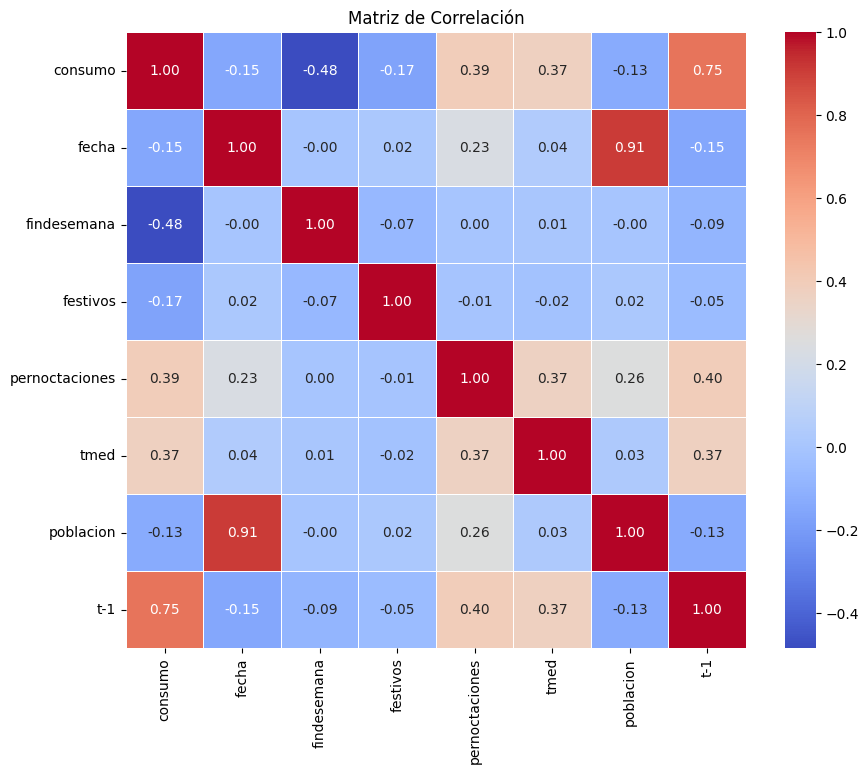

In [60]:
# Crear un mapa de calor con seaborn
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

## IV. Modelo LSTM

### IV.I. Preparar datos

In [16]:
#Ordenar los datos cronologicamnte
df = df.sort_values(by='fecha')

In [17]:
# Definir características (X) y objetivo (y)
X = df.drop(columns=['consumo','fecha'])  
y = df['consumo']

In [18]:
# Escalar los datos con MinMaxScaler (LSTM es sensible a la escala de los datos)
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [19]:
# Dividir en conjunto de entrenamiento y prueba (manteniendo el orden temporal)
train_size = int(len(X) * 0.9)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

In [20]:
X_train

array([[0.        , 0.        , 0.39376538, 0.17305586, 0.        ,
        0.15985635],
       [0.        , 0.        , 0.39376538, 0.13898399, 0.        ,
        0.3648209 ],
       [0.        , 0.        , 0.39376538, 0.11880408, 0.        ,
        0.37921167],
       ...,
       [0.        , 0.        , 0.86464315, 0.57753139, 0.87227772,
        0.35461403],
       [0.        , 0.        , 0.86464315, 0.65459524, 0.87227772,
        0.38210409],
       [0.        , 0.        , 0.86464315, 0.57799097, 0.87227772,
        0.41373896]])

In [21]:
X_test

array([[0.        , 0.        , 0.86464315, 0.50968011, 0.87227772,
        0.39355594],
       [1.        , 0.        , 0.86464315, 0.43290872, 0.87227772,
        0.34271107],
       [1.        , 0.        , 0.86464315, 0.41345997, 0.87227772,
        0.22605233],
       ...,
       [0.        , 0.        , 0.56767842, 0.34122175, 1.        ,
        0.13356221],
       [0.        , 0.        , 0.56767842, 0.40600218, 1.        ,
        0.28671869],
       [0.        , 1.        , 0.56767842, 0.40746449, 1.        ,
        0.28175954]])

In [32]:
# Crear secuencias de tiempo para LSTM
time_steps = 2 # Esto significa que la predicción se basará en los último dia
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)
print(f"Forma de X_train_seq: {X_train_seq.shape}")  # Debe ser (samples, time_steps, features)

Forma de X_train_seq: (1750, 2, 6)


### IV.II. Definir modelo LSTM

In [33]:
# Definir el modelo LSTM
model = Sequential()

In [34]:
# Primera capa LSTM con 50 unidades y dropout para regularización
model.add(LSTM(16, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.2))
# Segunda capa LSTM
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
# Capa de salida para la predicción continua de la demanda de electricidad
model.add(Dense(1))

C:\Users\minip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

In [36]:
# Mostrar el resumen del modelo
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 2, 16)          │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,777 (30.38 KB)

 Trainable params: 7,777 (30.38 KB)

 Non-trainable params: 0 (0.00 B)

### IV.III Entrenamiento del Modelo

In [37]:
# Entrenamiento conm 100 epocas
history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_data=(X_test_seq, y_test_seq))

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0700 - val_loss: 0.0183
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169 - val_loss: 0.0119
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0142 - val_loss: 0.0080
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0127 - val_loss: 0.0052
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113 - val_loss: 0.0050
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0114 - val_loss: 0.0058
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0105 - val_loss: 0.0051
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091 - val_loss: 0.0052
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0087 - val_loss: 0.0041
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081 - val_loss: 0.0052
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077 - val_loss: 0.0038
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0

### IV.IV. Evaluacion del Modelo

In [38]:
# Evaluar el modelo en el conjunto de prueba
loss = model.evaluate(X_test_seq, y_test_seq)
print(f'Loss: {loss}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024
Loss: 0.0025793069507926702


In [39]:
#Comprobar la prediccion
# Predecir los valores de prueba
y_pred_scaled = model.predict(X_test_seq)
# Desescalar las predicciones y los valores reales para comparar
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_true = scaler_y.inverse_transform(y_test_seq)
# Comparar las primeras predicciones con los valores reales
print(f"Predicciones: {y_pred[:5].flatten()}")
print(f"Valores reales: {y_test_true[:5].flatten()}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Predicciones: [ 7706988.5  9902818.   9965252.  10033672.   9383467. ]
Valores reales: [ 7361779. 10118354.  9872977.  9803152. 10092089.]


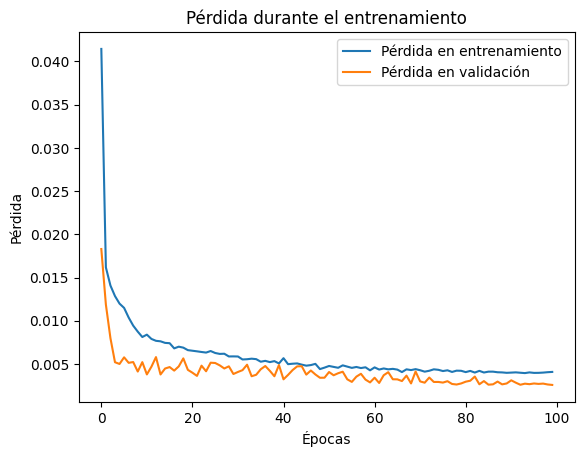

In [40]:
# Visualizar la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

## V. Guardar modelo no vaya a ser que se nos borre 

In [41]:
#Extraccion del modelo en la carpeta modelos
model.save('../models/modelo_servicios_Def.h5')

In [42]:
# Guardamos el objeto escalador x con pickle
with open('scaler_X_serv.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)

In [43]:
# Guardamos el objeto escalador y con pickle
with open('scaler_y_serv.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)